# Pre-Work

In [1]:
# Load modules
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
# Set memory limit on GPU to keep it from freezing up when fitting TensorFlow models later
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB * 2 of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], \
                                                                [tf.config.experimental.\
                                                                 VirtualDeviceConfiguration\
                                                                 (memory_limit=1024 * 3)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Inspect Training Data Composition

In [3]:
# Change directory
os.chdir('../data/raw')

In [4]:
# Load csv file with training set info
df = pd.read_csv('driver_imgs_list.csv')
df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


The 'subject' column contains a different ID for each unique person in the training data.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subject    22424 non-null  object
 1   classname  22424 non-null  object
 2   img        22424 non-null  object
dtypes: object(3)
memory usage: 525.7+ KB


In [7]:
# Pull lists of unique subjects and classes
sublist = df.subject.unique()
classlist = df.classname.unique()

## Inspect subject composition

In [8]:
# Pull value counts of each subject and put into separate dataframe
subjects = pd.DataFrame(df['subject'].value_counts())
subjects = subjects.reset_index().rename(columns={'index':'subject', 'subject':'counts'})

In [9]:
# Append summary stats at end of dataframe
subjects.loc['mean', :] = subjects.iloc[:len(sublist)].mean()
subjects.loc['std', :] = subjects.iloc[:len(sublist)].std()
subjects.loc['min', :] = subjects.iloc[:len(sublist)].min(numeric_only=True)
subjects.loc['median', :] = subjects.iloc[:len(sublist)].median()
subjects.loc['max', :] = subjects.iloc[:len(sublist)].max(numeric_only=True)

In [10]:
# Change column type to int
subjects[['counts']] = subjects[['counts']].astype(int)

In [11]:
subjects

,subject,counts
0,p021,1237
1,p022,1233
2,p024,1226
3,p026,1196
4,p016,1078
5,p066,1034
6,p049,1011
7,p051,920
8,p014,876
9,p015,875


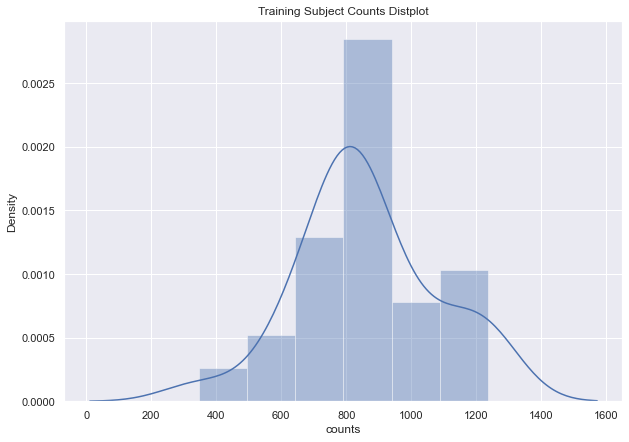

In [12]:
# Plot histogram to visualize spread of training subject frequency

fig = plt.figure(figsize=(10,7))
_ = plt.title('Training Subject Counts Distplot')
_ = sns.distplot(subjects.iloc[:len(sublist), :].counts)
_ = plt.show()
_ = plt.close()

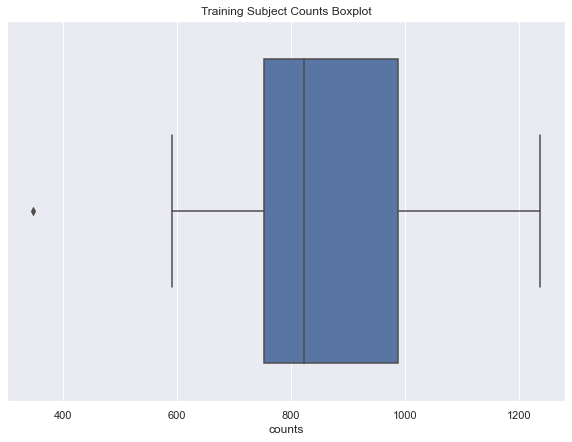

In [13]:
# Plot boxplot to visualize spread of subject frequency

fig = plt.figure(figsize=(10,7))
_ = plt.title('Training Subject Counts Boxplot')
_ = sns.boxplot(subjects.iloc[:len(sublist), :].counts)
_ = plt.show()
_ = plt.close()

## Inspect class composition

In [14]:
# Do the same thing with classes
classes = pd.DataFrame(df['classname'].value_counts())
classes = classes.reset_index().rename(columns={'index':'classname', 'classname':'counts'})

In [15]:
# Append summary stats at end of dataframe
classes.loc['mean', :] = classes.iloc[:len(classlist)].mean()
classes.loc['std', :] = classes.iloc[:len(classlist)].std()
classes.loc['min', :] = classes.iloc[:len(classlist)].min(numeric_only=True)
classes.loc['median', :] = classes.iloc[:len(classlist)].median()
classes.loc['max', :] = classes.iloc[:len(classlist)].max(numeric_only=True)

In [16]:
# Change column type to int
classes[['counts']] = classes[['counts']].astype(int)

In [17]:
classes

,classname,counts
0,c0,2489
1,c3,2346
2,c4,2326
3,c6,2325
4,c2,2317
5,c5,2312
6,c1,2267
7,c9,2129
8,c7,2002
9,c8,1911


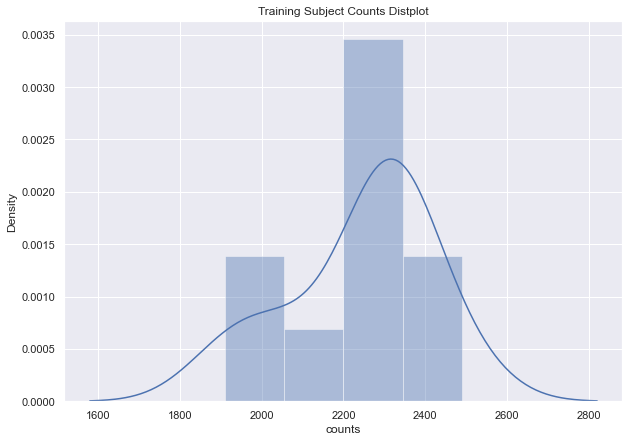

In [18]:
# Plot histogram to visualize spread of training class frequency

fig = plt.figure(figsize=(10,7))
_ = plt.title('Training Subject Counts Distplot')
_ = sns.distplot(classes.iloc[:len(classlist), :].counts)
_ = plt.show()
_ = plt.close()

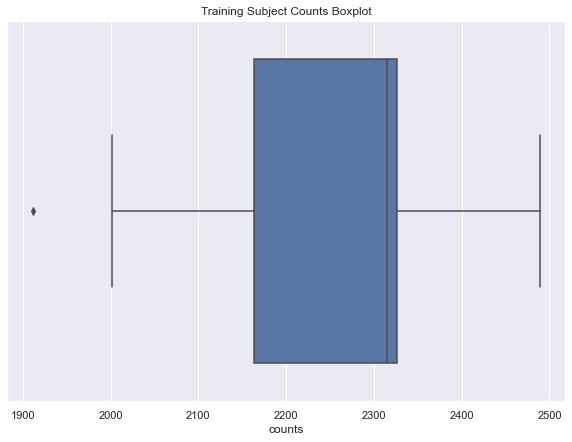

In [19]:
# Plot boxplot to visualize spread of class frequency

fig = plt.figure(figsize=(10,7))
_ = plt.title('Training Subject Counts Boxplot')
_ = sns.boxplot(classes.iloc[:len(classlist), :].counts)
_ = plt.show()
_ = plt.close()

###### It's clear that there is subject and class imbalance in the training set. This could prove problematic when training the model. Let's take a look and see how the class balance stands on a subject-by-subject basis

## Inspect class composition by subject

The goal is to see how the classes are imbalanced by subject

In [20]:
# Group aggregate sum class and subject
subbyclass = df.groupby(by=['subject', 'classname']).agg({'img':'count'})
subbyclass = subbyclass.reset_index().rename(columns={'img':'counts'})

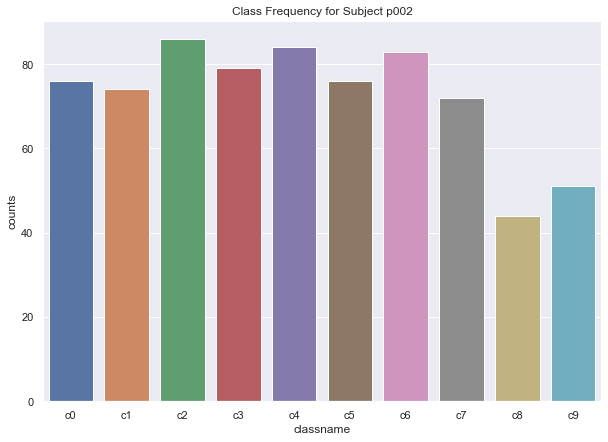

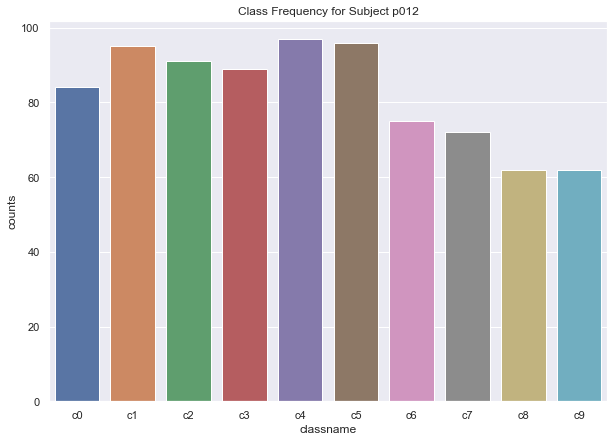

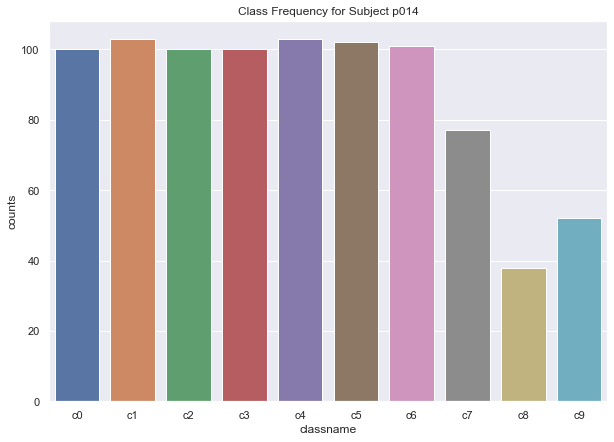

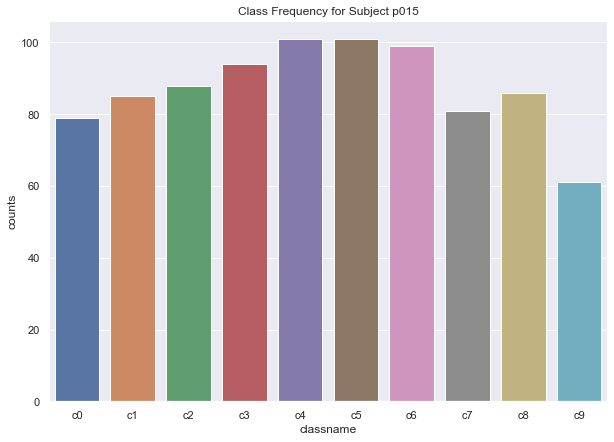

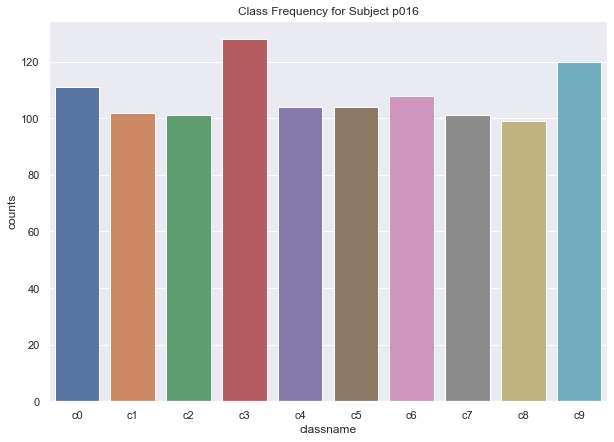

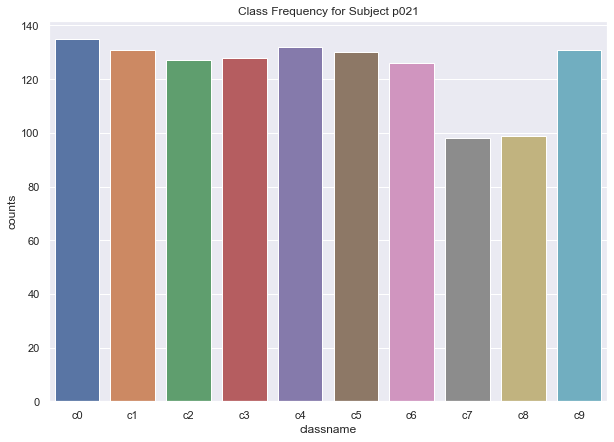

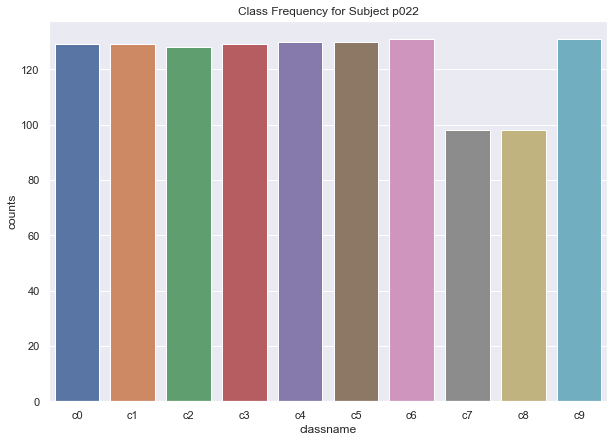

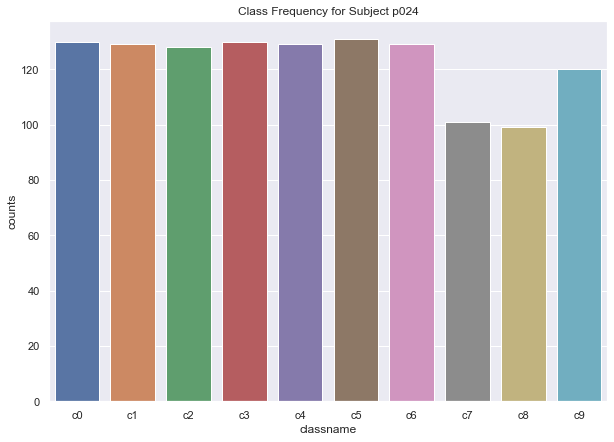

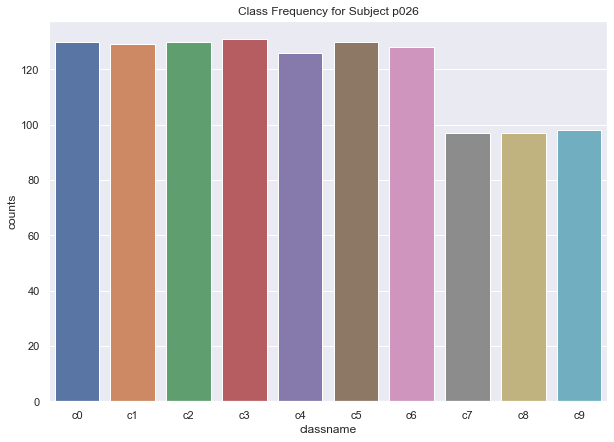

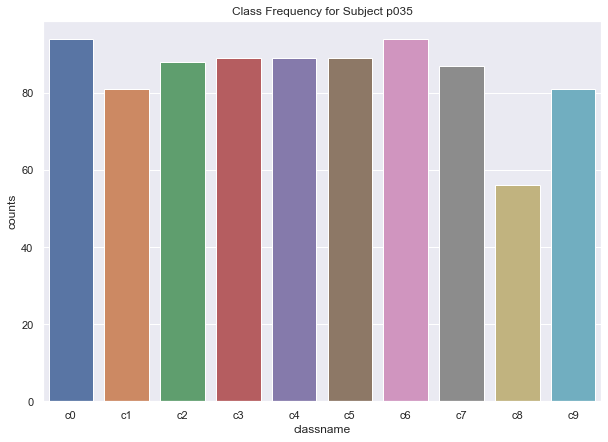

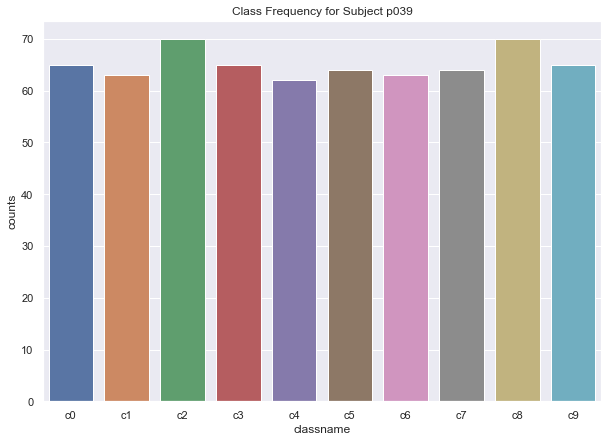

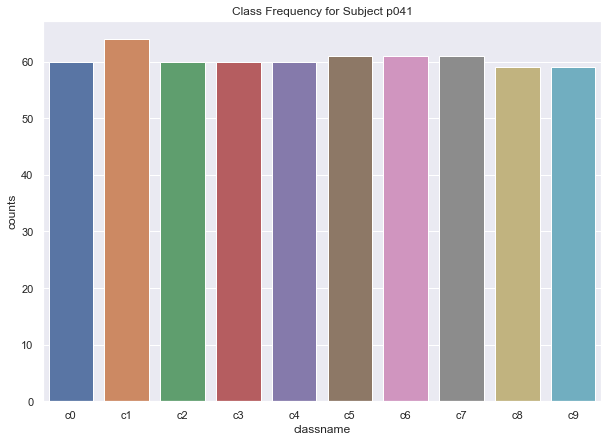

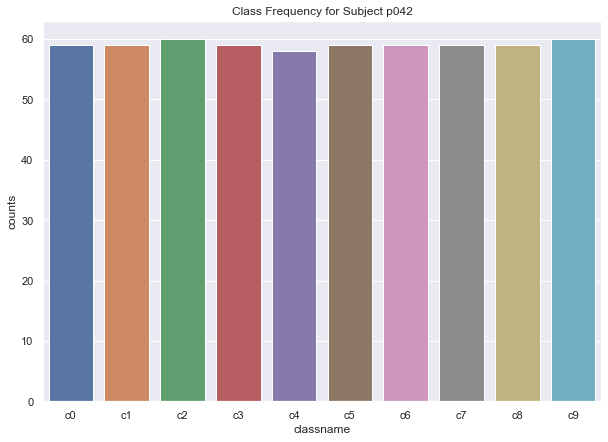

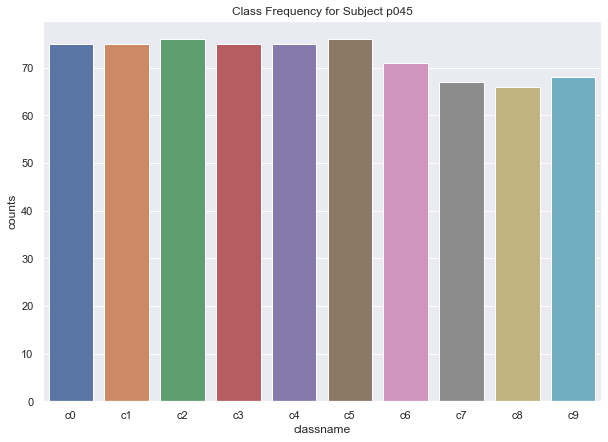

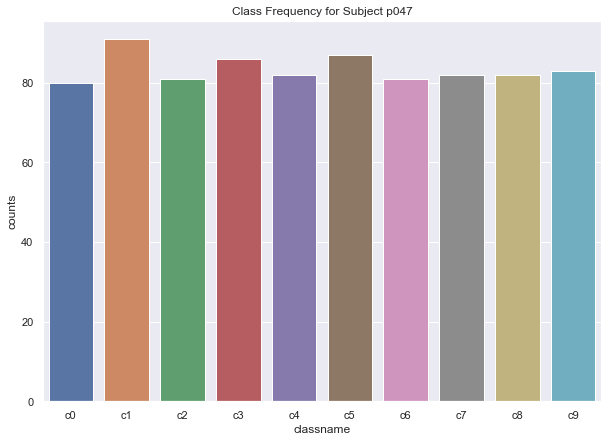

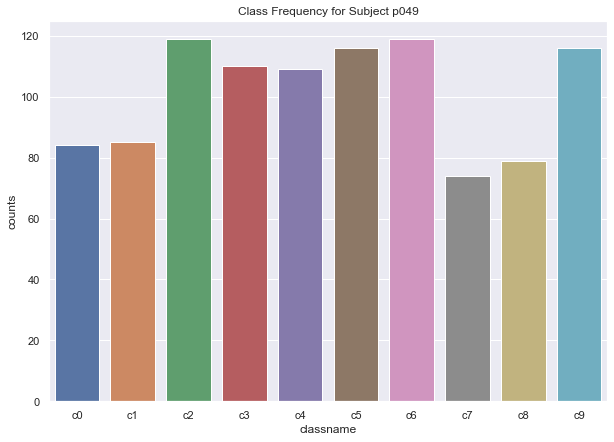

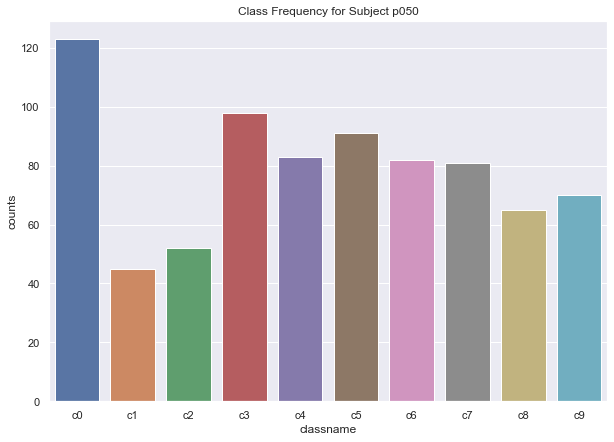

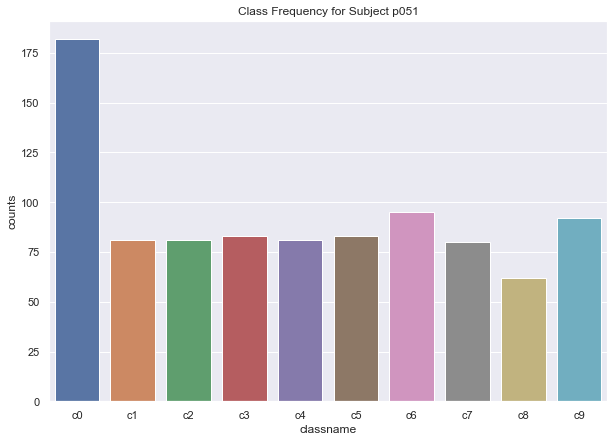

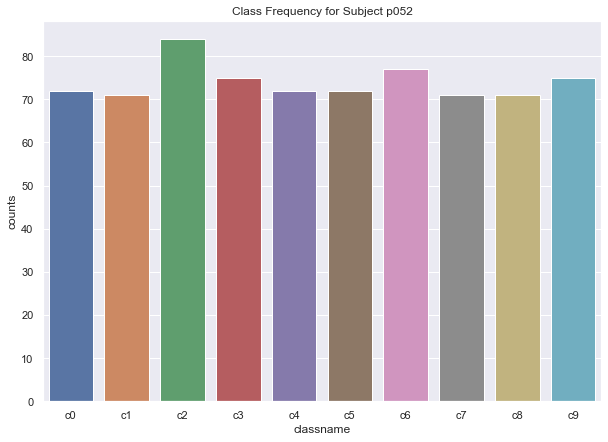

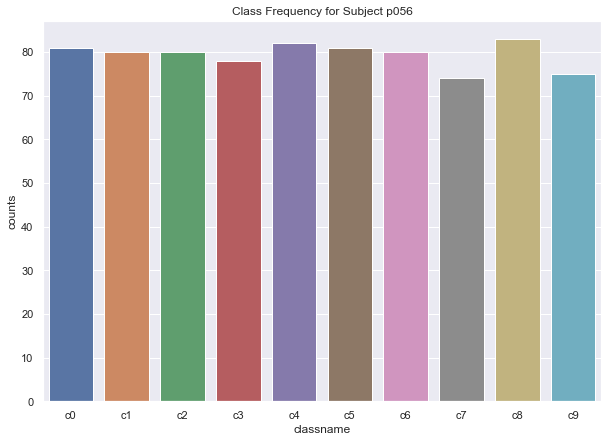

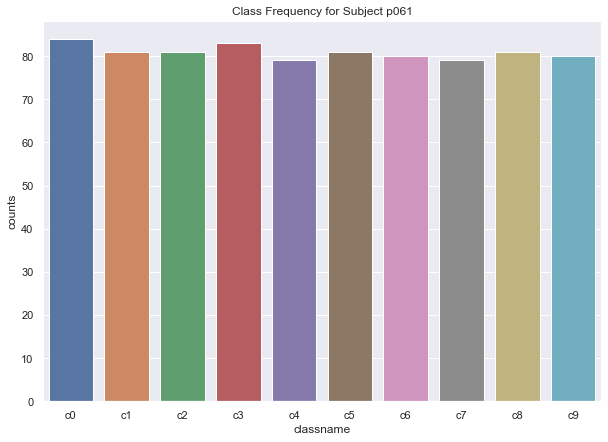

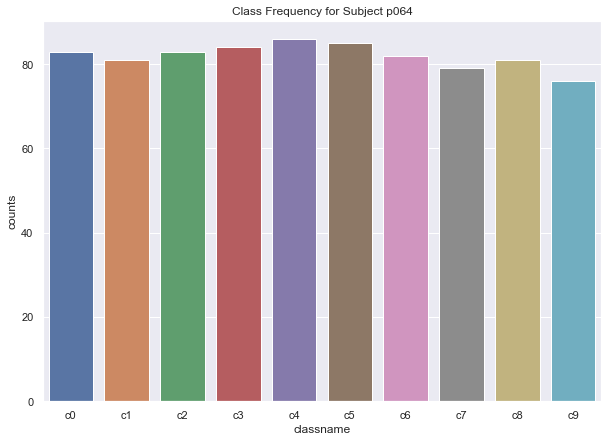

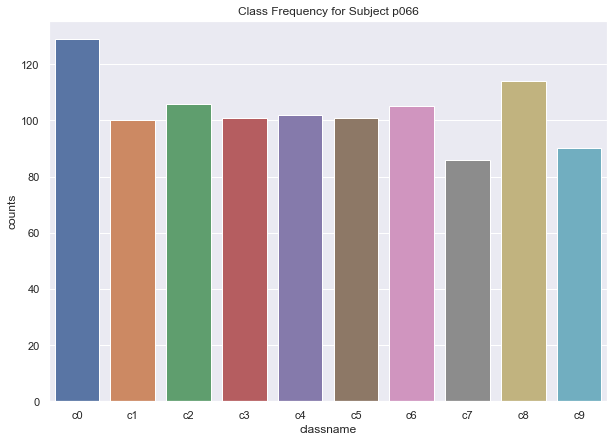

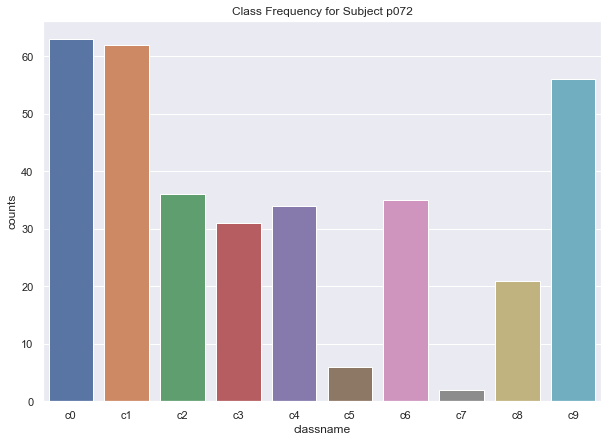

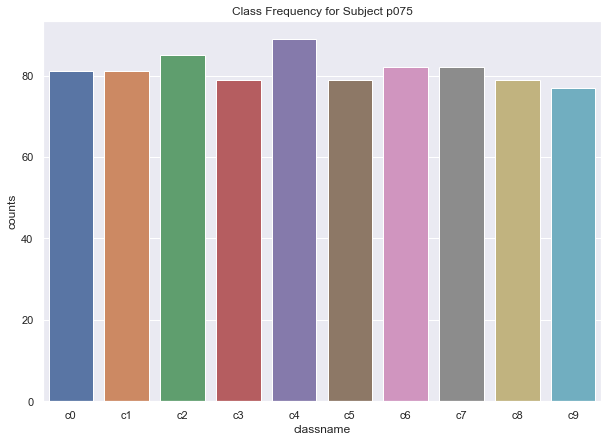

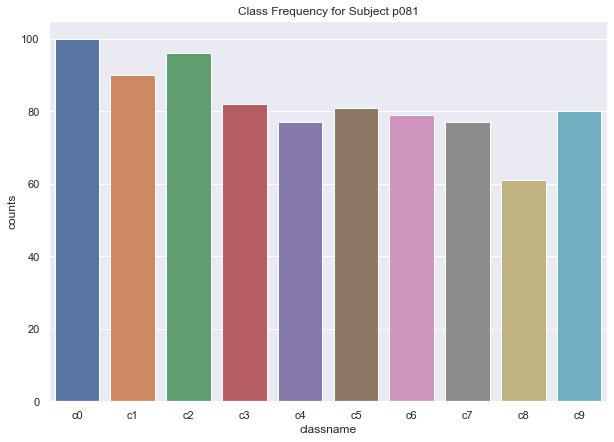

In [21]:
# Plot barplots for each subject to visualize spread of training class frequency
for i in sublist:
    fig = plt.figure(figsize=(10,7))
    _ = plt.title('Class Frequency for Subject ' + str(i))
    _ = sns.barplot(x='classname', y='counts', data=subbyclass.loc[subbyclass.subject == str(i)])
    _ = plt.show()
    _ = plt.close()

In [22]:
# Instantiate empty dataframe for class stats
classstats = pd.DataFrame(np.zeros([len(classlist),10]), \
                             columns=['class', \
                                      'mean', \
                                      'std', \
                                      'min', \
                                      'minsub', \
                                      '25%', \
                                      'median', \
                                      '75%', \
                                      'max', \
                                      'maxsub'], \
                             dtype='int')

# Designate string columns
classstats = classstats.astype({'class':'string', 'minsub':'string', 'maxsub':'string'})

In [23]:
# Fill dataframe with summary statistics using for loop
for i in range(len(classlist)):
    
    # Create filtered subdata frame by class
    idf = subbyclass.loc[subbyclass.classname == classlist[i], :]
    
    # Fill class column
    classstats.loc[i, 'class']= classlist[i]    
    
    # Fill mean column
    classstats.loc[i, 'mean'] = int(idf.counts.mean())
    
    #Fill std column
    classstats.loc[i, 'std'] = int(idf.counts.std())
    
    # Calculate min
    imin = idf.counts.min()
    
    # Fill min column
    classstats.loc[i, 'min'] = int(imin)
    
    # Fill minsub column
    classstats.loc[i, 'minsub'] = idf.loc[idf.counts == imin, 'subject'].iloc[0]
    
    # Fill 25% column
    classstats.loc[i, '25%'] = int(idf.counts.quantile(0.25))
    
    # Fill 50% column
    classstats.loc[i, 'median'] = int(idf.counts.median())
    
    # Fill 75% column
    classstats.loc[i, '75%'] = int(idf.counts.quantile(0.75))
    
    # Calculate max
    imax = idf.counts.max()
    
    # Fill max column
    classstats.loc[i, 'max'] = imax
    
    # Fill maxsub column
    classstats.loc[i, 'maxsub'] = idf.loc[idf.counts == imax, 'subject'].iloc[0]

In [24]:
# Append summary stats at end of dataframe
classstats.loc['mean', :] = classstats.iloc[:len(classlist)].mean()
classstats.loc['std', :] = classstats.iloc[:len(classlist)].std()
classstats.loc['min', :] = classstats.iloc[:len(classlist)].min(numeric_only=True)
classstats.loc['median', :] = classstats.iloc[:len(classlist)].median()
classstats.loc['max', :] = classstats.iloc[:len(classlist)].max(numeric_only=True)

In [25]:
# Change column datatype to int
classstats[['mean', 'std', 'min', '25%', 'median', '75%', 'max']] = \
classstats[['mean', 'std', 'min', '25%', 'median', '75%', 'max']].astype(int)

In [26]:
classstats

,class,mean,std,min,minsub,25%,median,75%,max,maxsub
0,c0,95,29,59,p042,76,84,120,182,p051
1,c1,87,22,45,p050,74,81,98,131,p021
2,c2,89,24,36,p072,80,85,100,130,p026
3,c3,90,24,31,p072,78,85,100,131,p026
4,c4,89,23,34,p072,77,85,102,132,p021
5,c5,88,27,6,p072,76,86,101,131,p024
6,c6,89,24,35,p072,77,82,104,131,p022
7,c7,77,19,2,p072,72,79,85,101,p016
8,c8,73,21,21,p072,61,75,85,114,p066
9,c9,81,24,51,p002,62,76,91,131,p021


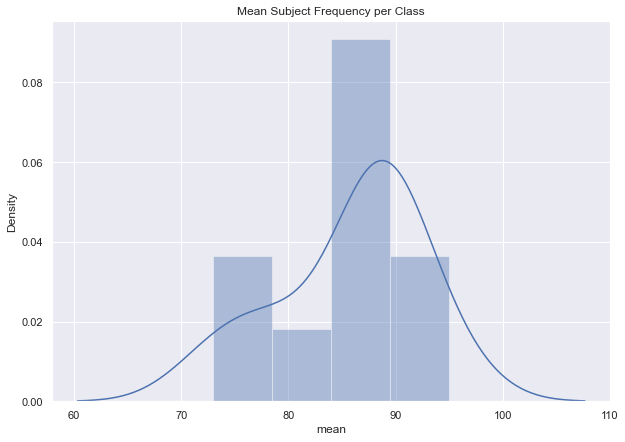

In [27]:
# Plot histogram to visualize spread of training class frequency
fig = plt.figure(figsize=(10,7))
_ = plt.title('Mean Subject Frequency per Class')
_ = sns.distplot(classstats.iloc[:len(classlist), :]['mean'])
_ = plt.show()
_ = plt.close()

## Inspect Subject Composition by Class

In [28]:
# Group aggregate sum class and subject
classbysub = df.groupby(by=['classname', 'subject']).agg({'img':'count'})
classbysub = classbysub.reset_index().rename(columns={'img':'counts'})

In [29]:
# Create empty dataframe
substats = pd.DataFrame(np.zeros([len(sublist),10]), \
                             columns=['subject', \
                                      'mean', \
                                      'std', \
                                      'min', \
                                      'minclass', \
                                      '25%', \
                                      'median', \
                                      '75%', \
                                      'max', \
                                      'maxclass'], \
                             dtype='int')

In [30]:
# Designate column types
substats = substats.astype({'subject':'string', 'minclass':'string', 'maxclass':'string'})

In [31]:
# Fill dataframe
for i in range(len(sublist)):
    
    idf = classbysub.loc[classbysub.subject == sublist[i], :]
    
    substats.loc[i, 'subject']= sublist[i]    
    
    substats.loc[i, 'mean'] = int(idf.counts.mean())
    
    substats.loc[i, 'std'] = int(idf.counts.std())
    
    imin = idf.counts.min()
    
    substats.loc[i, 'min'] = int(imin)
    
    substats.loc[i, 'minclass'] = idf.loc[idf.counts == imin, 'classname'].iloc[0]
    
    substats.loc[i, '25%'] = int(idf.counts.quantile(0.25))
    
    substats.loc[i, 'median'] = int(idf.counts.median())
                                    
    substats.loc[i, '75%'] = int(idf.counts.quantile(0.75))
    
    imax = idf.counts.max()
    
    substats.loc[i, 'max'] = imax
    
    substats.loc[i, 'maxclass'] = idf.loc[idf.counts == imax, 'classname'].iloc[0]
    
    

In [32]:
# Append summary stats at end of dataframe 
substats.loc['mean', :] = substats.iloc[:len(sublist)].mean()
substats.loc['std', :] = substats.iloc[:len(sublist)].std()
substats.loc['min', :] = substats.iloc[:len(sublist)].min(numeric_only=True)
substats.loc['median', :] = substats.iloc[:len(sublist)].median()
substats.loc['max', :] = substats.iloc[:len(sublist)].max(numeric_only=True)

In [33]:
# Designate column types as int
substats[['mean', 'std', 'min', '25%', 'median', '75%', 'max']] = \
substats[['mean', 'std', 'min', '25%', 'median', '75%', 'max']].astype(int)

In [34]:
substats

,subject,mean,std,min,minclass,25%,median,75%,max,maxclass
0,p002,72,14,44,c8,72,76,82,86,c2
1,p012,82,13,62,c8,72,86,94,97,c4
2,p014,87,23,38,c8,82,100,101,103,c1
3,p015,87,12,61,c9,82,87,97,101,c4
4,p016,107,9,99,c8,101,104,110,128,c3
5,p021,123,13,98,c7,126,129,131,135,c0
6,p022,123,13,98,c7,128,129,130,131,c6
7,p024,122,12,99,c8,122,129,129,131,c5
8,p026,119,15,97,c7,105,128,130,131,c3
9,p035,84,11,56,c8,82,88,89,94,c0


###### Looking at these charts, it seems like the best course of action would be to pick a number of samples to have each subject represented in each class. This would balance the subjects, classes, and subjects/class in the training set. The mean 25% quantile of subject occurance/class is 81. 

###### To make a nice even number, 80 samples of each subject will be represented in each class in the training set. To do this, a new dataframe will be generated, oversampling for subjects that are underrepressented and undersampling for those that are overrepressented. This new dataframe will be used to generate the cross-validation training data set

# Define Function for Sampling of Training Set

In [5]:
# Create column in dataframe with path to training images
df['imgpath'] = df[['classname', 'img']].apply(lambda x: '/'.join(x), axis=1)
df['imgpath'] = df[['imgpath']].apply(lambda x: 'imgs/train/' + x, axis=1)

In [6]:
# Export modified dataframe as csv
os.chdir('../processed')
df.to_csv('driver_image_list_processed.csv', index=False)

In [6]:
def trainsampling(data,
                  samples=80,
                  col1='subject',
                  col2='classname',
                  random_state=None):
    """
    Function iterates through all unique combinations of two columns of a dataframe and pulls random samples for
    each combination equal to the number called in the 'samples' argument. Function will sample with replacement
    if the total number of rows per combination is less than the 'samples' argument. Samples will be returned
    as a pandas DataFrame.
    """

    # Raise error if selected columns are numeric
    if pd.api.types.is_numeric_dtype(data[col1]) or pd.api.types.is_numeric_dtype(data[col2]):
        raise TypeError('Columns must not be numeric')

    # Create empty dataframe
    dftemp = pd.DataFrame(columns=data.columns)

    # Assign list variables for unique values in each column
    col1ls = data.loc[:, col1].unique()
    col2ls = data.loc[:, col2].unique()

    # For loops to filter all combinations of the two columns and sample accordingly
    for i in col1ls:
        for j in col2ls:
            subset = data.loc[data.loc[:, col1] == i]
            subset = subset.loc[subset.loc[:, col2] == j]

            if len(subset) < samples:
                dftemp = pd.concat([dftemp, subset.sample(samples, replace=True, random_state=random_state)])

            else:
                dftemp = pd.concat([dftemp, subset.sample(samples, replace=False, random_state=random_state)])

    return dftemp

In [13]:
sampledtrain = trainsampling(df, random_state=42)

In [14]:
sampledtrain

,subject,classname,img,imgpath
51,p002,c0,img_13073.jpg,imgs/train/c0/img_13073.jpg
14,p002,c0,img_5585.jpg,imgs/train/c0/img_5585.jpg
71,p002,c0,img_48187.jpg,imgs/train/c0/img_48187.jpg
60,p002,c0,img_98115.jpg,imgs/train/c0/img_98115.jpg
20,p002,c0,img_66355.jpg,imgs/train/c0/img_66355.jpg
...,...,...,...,...
22364,p081,c9,img_95966.jpg,imgs/train/c9/img_95966.jpg
22404,p081,c9,img_18412.jpg,imgs/train/c9/img_18412.jpg
22415,p081,c9,img_23818.jpg,imgs/train/c9/img_23818.jpg
22358,p081,c9,img_54961.jpg,imgs/train/c9/img_54961.jpg


## Datagen from DataFrame to train Keras

In [8]:
datagen = keras.preprocessing.image.ImageDataGenerator()
train = datagen.flow_from_dataframe(sampledtrain, \
                                    x_col='imgpath', \
                                    y_col='classname', \
                                    target_size=(480, 640))

Found 20800 validated image filenames belonging to 10 classes.


It works!

## Function for Cross-Validation Model Evaluation

In [17]:
def cvmodeleval(model,
                data,
                itercol='subject',
                n_iterations=1,
                epochs=1,
                steps_per_epoch=None,
                validation_steps=None,
                target_size=(227, 227)):
    """
    Define function to perform cross-validation on a model. Function will split the data into training and validation
    sets by each unique value in the itercol. In this case the itercol represents unique subjects present in each
    photo. The goal is to build a model that generalizes well to all subjects, and doesn't just remember the specific
    subjects present in the training set.

    The model will be reset to default parameter weights each iteration and will be fit to the cross-validation data.
    The maximum validation_accuracy achieved during each round of fitting will be logged into a pandas DataFrame.

    n_iterations represents the total number of times the full iteration loop will run, thus allowing multiple
    data points to be collected for each unique value in the itercol.
    """

    # Raise error if selected columns are numeric
    if pd.api.types.is_numeric_dtype(data[itercol]):
        raise TypeError('Columns must not be numeric')

    # Create empty lists
    iterations = []
    validation_subjects = []
    validation_accuracies = []

    # Save initial default model weights
    wsave = model.get_weights()

    # Instantiate image data generator
    datagen = keras.preprocessing.image.ImageDataGenerator()

    # Designate model checkpoint and callbacks_list
    checkpoint = ModelCheckpoint('weights.hdf5',
                                 mode='max',
                                 monitor='val_accuracy',
                                 save_best_only=True)

    earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0.05, patience=3)

    callbacks_list = [checkpoint, earlystop]

    # n_iteration for loop
    for i in range(n_iterations):

        # Initialize Substep counter
        counter = 0

        for j in data[itercol].unique():
            # Substep counter
            counter += 1

            # Print iteration and substep progress
            print('CV iteration ' + str(i + 1))
            print('Substep ' + str(counter) + ' of ' + str(len(data[itercol].unique())))

            # reset model states for fresh training
            model.set_weights(wsave)

            # Split train and test sets, iterating through each subject to be excluded from training
            cvtrain = data.loc[data.loc[:, 'subject'] != j]
            cvtest = data.loc[data.loc[:, 'subject'] == j]

            # Split training data
            train = datagen.flow_from_dataframe(cvtrain,
                                                x_col='imgpath',
                                                y_col='classname',
                                                target_size=target_size)
            # Split validation data
            val = datagen.flow_from_dataframe(cvtest,
                                              x_col='imgpath',
                                              y_col='classname',
                                              target_size=target_size)
            # Fit model
            model.fit(train,
                      epochs=epochs,
                      steps_per_epoch=steps_per_epoch,
                      validation_data=val,
                      validation_steps=validation_steps,
                      callbacks=callbacks_list)

            # Append lists
            iterations.append(i + 1)
            validation_subjects.append(j)
            validation_accuracies.append(round(max(model.history.history['val_accuracy']), 3))

            # Clear tf backend
            tf.keras.backend.clear_session()

    # Fill dataframe with stats
    dftemp = pd.DataFrame({'iteration': iterations, 'validation_subject': validation_subjects,
                           'validation_accuracy': validation_accuracies})

    return dftemp

## Function Combining Sampling and Cross-Validation

In [18]:
def samplecv(model,
             data,
             isampled=1,
             samples=80,
             col1='subject',
             col2='classname',
             itercol='subject',
             n_iterations=1,
             epochs=3,
             steps_per_epoch=None,
             validation_steps=None,
             target_size=(227, 227),
             random_state=None):
    """
    Combine trainsampling and cvmodeleval functions so that the training data can be resampled numerous times
    and run through cvmodeleval, to get a better representation of the model's performance.
    """

    modelsave = model

    for k in range(isampled):

        # Save and print out iteration info
        fullit = str(k + 1)
        print('Resample iteration ' + fullit)

        # Perform training sampling
        ts = trainsampling(data=data, samples=samples, col1=col1, col2=col2, random_state=random_state)


        # Run CV model evaluation
        stats = cvmodeleval(model=modelsave, data=ts, itercol=itercol, n_iterations=n_iterations, epochs=epochs,
                            steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, target_size=target_size)

        if k == 0:
            combinedstats = stats

            combinedstats.rename(columns={'validation_accuracy': 'val_acc1'}, inplace=True)

        else:
            combinedstats['val_acc' + fullit] = stats['validation_accuracy']

    return combinedstats
